<a href="https://colab.research.google.com/github/SadatArefin/Run-MicMac/blob/main/Historical_Aerial_TiePtExtraction_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The tie-points extraction in diachronic images in `MicMac`

In this tutorial we will introduce you to tie-points extraction in diachronic images (only aerial images) in MicMac. (For processing both satellite and aerial images, please refer to [Historical_Satellite_TiePtExtraction_pipeline.ipynb](https://colab.research.google.com/drive/14okQ8bBhEZmy6EGRIQvazTqrN39oc_K5)) The goal of the exercise is to extract tie-points between diachronic images. We refer to images obtained within one epoch as intra-epoch images, and images obtained at different epochs as inter-epoch images.

Given a set of images in 2 epochs, our pipeline performs an intra-epoch processing, followed by an inter-epoch processing. The latter consists of 2 main steps: rough co-registration and precise matching.

After setting-up MicMac and downloading the dataset, the pipeline is as follows:

1. Intra-epoch processing
<details>
  <summary>[Click to expand]</summary>

      1.1. ***Feature matching***: Applying feature matching based on SIFT on images within the same epoch.

      1.2. ***Relative orientation***: Computing relative orientations for each epoch.

      1.3. ***DSM generation***: Computing DSM of each epoch based on relative orientations.

      If the orientation of each epoch is provided, the step 1.2 can be skipped.


</details>

  2. Inter-epoch processing
<details>
  <summary>[Click to expand]</summary>

      2.1. ***Automated pipeline***

  We provide automated pipeline which will launch the whole inter-epoch processing pipeline by calling several subcommands.
  
      2.2. ***Deep-dive in the pipeline's submodules***
  
  We also provide deep-dive to explain all the submodules used in the automated pipeline. It consists of:

      * 2.2.1. ***Rough co-registration***

     This step is for roughly co-registering the DSMs and image orientations from different epochs.

      * 2.2.2. ***Precise matching***

  This step is for obtaining precise tie-points under the guidance of rough co-registration.

  If the 2 epochs are already co-registered (e.g. both epochs are georeferenced), the step 2.2.1 can be skipped.

</details>

The full workflow is displayed below:

<center>
  <img src="https://drive.google.com/uc?id=1OC-qec7MVVmE6W_iC11wpaDreqa_P5B0" height=320pix/>
  <br>
</center>

<center>
Figure. Our workflow
  <br>
</center>


For more information please refer to:

* ***Publication***: L. Zhang, E. Rupnik, M. Pierrot-Deseilligny, [Feature matching for multi-epoch historical aerial images](https://www.sciencedirect.com/science/article/pii/S0924271621002707), ISPRS journal of photogrammetry and remote sensing, 182 (2021), pp. 176-189 ([PDF](https://arxiv.org/abs/2112.04255))
* ***Code***: MicMac, GitHub, https://github.com/micmacIGN/micmac/tree/master/src/uti_phgrm/TiePHistorical, 2021.
* ***Introduction video***: [Feature matching for multi-epoch historical aerial images](https://youtu.be/YnF-F0UJaSM)
* ***Slides***: [Feature matching for multi-epoch historical aerial images](https://drive.google.com/uc?id=16sJZiY3sTZSRZKBzpy2IHVloCLj6pEwP)
* ***Blog***: [Feature matching for multi-epoch historical aerial images](https://rfpt-sfpt.github.io/blog/feature%20matching/historical%20images/multi-epoch/pose%20estimation/self-calibration/2021/11/17/Lulin-ZHANG-LaSTIG.html)
* ***Project website***: [Feature matching for multi-epoch historical aerial images](https://www.umr-lastig.fr/ewelina-rupnik/historicalfeatures.html)

> The notion of the "tie-point" and the "correspondence" are synonymous in this tutorial and the publication.

> The datasets in our publication will be soon published in an open-access repository.


*Contacts:*

*lulin.zhang.whu@gmail.com*

*ewelina.rupnik@ign.fr*


> ***License***: We adopt SuperGlue in our pipeline. Note that you can only use SuperGlue [for academic or non-profit organization noncommercial research](https://github.com/magicleap/SuperGluePretrainedNetwork/blob/master/LICENSE). Full paper PDF: [SuperGlue: Learning Feature Matching with Graph Neural Networks](https://arxiv.org/abs/1911.11763).



## Projet set-up

### Download and compile MicMac & dependencies

In [ ]:
import os
from os.path import exists, join, basename, splitext
import numpy as np
import cv2
import matplotlib.pyplot as plt

Dependencies_install = True
MicMac_clone = True
MicMac_cmake = True
MicMac_build = True

YOUR_PATH = '/content/'#MyDrive/micmac/satellites/'
!cd $YOUR_PATH
!pwd


if Dependencies_install:
  !apt update
  !apt install -y cmake
  !pip install dlib
  !apt-get install imagemagick proj-bin exiv2
  !pip install wget
  !pip install -U --no-cache-dir gdown --pre

if MicMac_clone:
  if not exists(YOUR_PATH+'micmac/'):
    git_repo_url = 'https://github.com/micmacIGN/micmac.git'
    !git clone $git_repo_url

if MicMac_cmake:
  !cd micmac
  if not exists(YOUR_PATH+'micmac/build'):
    !mkdir $YOUR_PATH"micmac/build"

  !cd $YOUR_PATH"micmac/build"
  !cmake $YOUR_PATH"micmac" -DBUILD_POISSON=OFF

  if MicMac_build:
    !make install -j28



/content
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/pp

### Add environmental variable

In [ ]:
import os
os.environ['PATH'] += ":/content/micmac/bin"
!echo $PATH

# if you can see the commands printed to the screen, everything is OK
!mm3d

/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/content/micmac/bin

************************************************************************ 
**                                                                    ** 
**    MicMac: a  free open source project  for photogrammetry         ** 
**     hosted at Ecole Nationale des Sciences Geographiques           ** 
**               in Marne-la-Vallee, for IGN-France                   ** 
**                                                                    ** 
**                                                                    ** 
**  The project is funded by :                                        ** 
**                                                                    ** 
**  - Institut National de l'Information Geographique et Forestiere   ** 
**    (IGN main funder since 2003)                                    ** 
**  - the

### Create virtualenv, clone SuperGluePretrainedNetwork and install depedencies

In [ ]:
%cd $YOUR_PATH"micmac/src/uti_phgrm/TiePHistorical/"
!pwd
!bash ./install.sh /usr/local/bin/python

/content/micmac/src/uti_phgrm/TiePHistorical
/content/micmac/src/uti_phgrm/TiePHistorical
/usr/local/bin/python
     |████████████████████████████████| 8.6 MB 16.9 MB/s 
     |████████████████████████████████| 461 kB 49.4 MB/s 
Cloning into 'SuperGluePretrainedNetwork'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 182 (delta 10), reused 6 (delta 3), pack-reused 157
Receiving objects: 100% (182/182), 118.85 MiB | 20.95 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Switched to a new branch 'test'
HEAD is now at c0626d5 Merge pull request #30 from ddetone/fix_phototourism_test_pairs
created virtual environment CPython3.7.12.final.0-64 in 1093ms
  creator CPython3Posix(dest=/content/micmac/src/uti_phgrm/TiePHistorical/python_env/magicleap_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy,

### Download the dataset

The dataset consists of:
  * 6 images taken in epoch 1971 (tif)
  * 4 images taken in epoch 1981 (tif)
  * 2 lists that contain all the RGB images of each epoch (txt)
  * 2 fiducial mask files of each epoch (tif and xml)
  * 1 configuration file of the camera (xml)

In [ ]:
from os.path import exists

%cd $YOUR_PATH
!pwd
# download data
dataset_url = 'https://drive.google.com/uc?id=1W299CM_lZk2KIgLV0odjxanz74T6Humy'
!gdown $dataset_url -O "historical_data.tar.gz"

# unpack
#!unzip historical_data.zip $YOUR_PATH
!tar -xf historical_data.tar.gz -C $YOUR_PATH

%cd $YOUR_PATH'historical_data'

# utility functions to visualise tie-points
utils_url='https://drive.google.com/uc?id=1ATO1Nz_aXApxVnm6l7x1xappGXtcjuvp'
!gdown $utils_url -O "mm3d_utils.py"

/content
/content
Downloading...
From: https://drive.google.com/uc?id=1W299CM_lZk2KIgLV0odjxanz74T6Humy
To: /content/historical_data.tar.gz
100% 26.3M/26.3M [00:00<00:00, 56.7MB/s]
/content/historical_data
Downloading...
From: https://drive.google.com/uc?id=1ATO1Nz_aXApxVnm6l7x1xappGXtcjuvp
To: /content/historical_data/mm3d_utils.py
100% 3.18k/3.18k [00:00<00:00, 4.57MB/s]


## 1. Intra-epoch processing

We will firstly process each epoch individually to obtain:
* intra-epoch tie-points
* relative orientations
* DSMs

### 1.1. Feature matching



#### 1.1.1. Epoch 1981

##### Recover tie-points

Extract SIFT tie-points between images within the same epoch with command "Tapioca" (i.e., a version of SIFT). The input, output and parameter interpretation of the command "Tapioca" are listed below:

Input:

- `images`

Output:

- `SIFT tie-points`

The meaning of obligatory parameters:
- `MulScale`: Compute tie-points for images in low resolution and then for high resolution
- `OIS-Reech_IGNF_PVA_1-0__1981.*tif`: the pattern of input images
- `500`: Size of Low Resolution Images
- `-1`: Size of High Resolution Images, -1 means original resulution of the input image

The meaning of optional parameters:
- `PostFix`: Homologue extenion for NB/NT mode

In [ ]:
!mm3d Tapioca MulScale OIS-Reech_IGNF_PVA_1-0__1981.*tif 500 -1 PostFix=_1981

"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif-MDT-4227.xml
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0065.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0065.tif-MDT-4227.xml
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0082.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0082.tif-MDT-4227.xml
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0083.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0083.tif-MDT-4227.xml
--- using detecting tool : [mm3d:Sift]
--- using matching tool : [mm3d:Ann]
"/content/micmac/bin/mm3

##### Remove tie-points on the fiducial marks

###### Create a mask
Since historical images contain fiducial marks and they would yield nonsensical tie-points, we create a mask to remove any points in the vicinity of the fiducial marks. To create the mask we use the "SaisieMasq" program:

The input, output and parameter interpretation of the command "SaisieMasq" are listed below:

Input:
- `image`

Output:
- `mask image drawn by user`

The meaning of obligatory parameters:
- `OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0083.tif`: input image

The meaning of optional parameters:
- `Name`: the output mask image

> mm3d SaisieMasq OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0083.tif Name=Fiducial_marks_masq-1981-3.tif

> Note: As "SaisieMasq" couldn't be launched under this platform, we skip this step and use the mask files provided by the author instead.


###### Apply the mask to remove tie-points
Once the mask created, we will use it to remove all tie-points outside the mask with "HomolFilterMasq".

The input, output and parameter interpretation of the command "HomolFilterMasq" are listed below:

Input:
- `images; tie-points; mask file`

Output:
- `filtered tie-points`

The meaning of obligatory parameters:
- `OIS-Reech_IGNF_PVA_1-0__1981.*tif`: the pattern of input images

The meaning of optional parameters:
- `GlobalMasq`: Global Masq to add to all image
- `PostIn`: Post for Input dir Hom, Def=
- `PostOut`: Post for Output dir Hom, Def=MasqFiltered

In [ ]:
!mm3d HomolFilterMasq OIS-Reech_IGNF_PVA_1-0__1981.*tif GlobalMasq=Fiducial_marks_masq-1981-3.tif PostIn=_1981 PostOut=_1981-Masq

"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
Prep Reste 4
Prep Reste 3
Prep Reste 2
Prep Reste 1
Filter Reste 4
Filter Reste 3
Filter Reste 2
Filter Reste 1


##### Visualise tie-points

###### Binary to txt conversion
The resulting tie-points are in binary format. To visualise them we will convert them to a txt format. We can use the same command "HomolFilterMasq" to perform this conversion.

The input, output and parameter interpretation of the command "HomolFilterMasq" are listed below:

Input:
- `images; tie-points in binary format`

Output:
- `tie-points in txt format`

The meaning of obligatory parameters:
- `OIS-Reech_IGNF_PVA_1-0__1981.*tif`: the pattern of input images

The meaning of optional parameters:
- `PostIn`: Post for Input dir Hom, Def=
- `PostOut`: Post for Output dir Hom, Def=MasqFiltered
- `ANM`: Accept no mask, def = true if MasqGlob and false else
- `ExpTxt`: Ascii format for in and out, def=false
- `ExpTxtOut`: Ascii format for out when != in , def=ExpTxt

In [ ]:
!mm3d HomolFilterMasq "OIS-Reech_IGNF_PVA_1-0__1981.*tif" PostIn=_1981 PostOut=_1981-TXT ANM=1 ExpTxt=0 ExpTxtOut=1

"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
Prep Reste 4
Prep Reste 3
Prep Reste 2
Prep Reste 1
Filter Reste 4
Filter Reste 3
Filter Reste 2
Filter Reste 1


###### Visualise an example

                    image1 1981                                          image2 1981


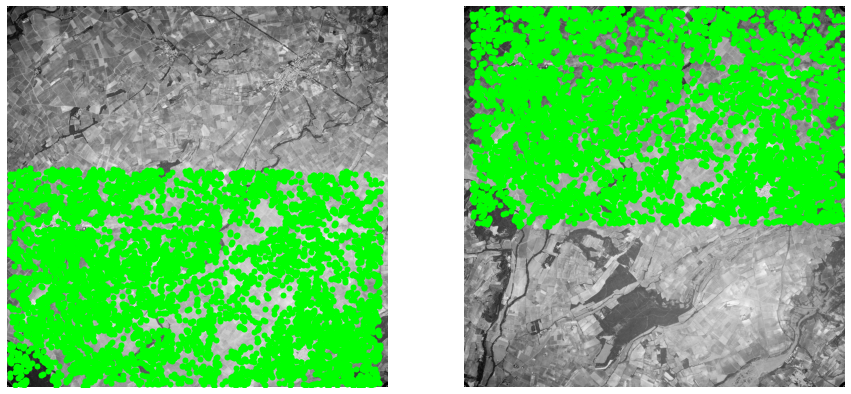

In [ ]:
import mm3d_utils

ImgName1 = 'OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif'
ImgName2 = 'OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0065.tif'
aIm1 = cv2.imread(ImgName1,cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread(ImgName2,cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom('Homol_1981-TXT/Pastis'+ImgName1+'/'+ImgName2+'.txt')

print('                    image1 1981                                          image2 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

##### Tie-points reduction

The intra-epoch tie-points are generally very abundant. We reduce their quantity for several reasons:
* quantity of tie points does not impact the quality of the bundle adjustement (only the distribution is crucial)
* we wish to speed-up the bundle adjustement
* we want to "balance" the number of inter- and intra-epoch tie-points

To ensure good distribution and high multiplicity of the "reduced" tie-points, MicMac first computes the relative orientation between pairs of images:
*  TestLib NO_AllOri2Im

In [ ]:
!mm3d TestLib NO_AllOri2Im OIS-Reech_IGNF_PVA_1-0__1981.*tif SH=_1981-Masq
!mm3d Ratafia OIS-Reech_IGNF_PVA_1-0__1981.*tif SH=_1981-Masq Out=_1981-Ratafia

"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
"OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif": 1 matches.
"OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0065.tif": 1 matches.
"NKS-Set-HomolOfOneImage@_1981-Masq@dat@OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif": 3 matches.
"NKS-Set-HomolOfOneImage@_1981-Masq@dat@OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0065.tif": 3 matches.
"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
"OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0082.tif": 1 matches.
"NKS-Set-HomolOfOneImage@_1981-Masq@dat@OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0082.tif": 3 matches.
"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
"OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0083.tif": 1 matches.
"NKS-Set-HomolOfOneImage@_1981-Masq@dat@O

To visualise the reduced tie-points, we will convert them to a txt format using "HomolFilterMasq".

In [ ]:
!mm3d HomolFilterMasq "OIS-Reech_IGNF_PVA_1-0__1981.*tif" PostIn=_1981-Ratafia PostOut=_1981-Ratafia-TXT ANM=1 ExpTxt=0 ExpTxtOut=1

"OIS-Reech_IGNF_PVA_1-0__1981.*tif": 4 matches.
Prep Reste 4
Prep Reste 3
Prep Reste 2
Prep Reste 1
Filter Reste 4
Filter Reste 3
Filter Reste 2
Filter Reste 1


An example of the reduced tie-points are visualised below:

                    image1 1981                                          image2 1981


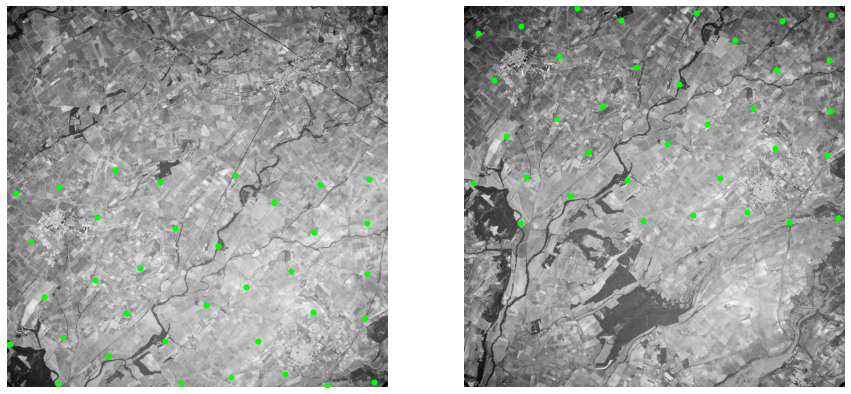

In [ ]:
import mm3d_utils

ImgName1 = 'OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif'
ImgName2 = 'OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0065.tif'
aIm1 = cv2.imread(ImgName1,cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread(ImgName2,cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom('Homol_1981-Ratafia-TXT/Pastis'+ImgName1+'/'+ImgName2+'.txt')

print('                    image1 1981                                          image2 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

#### 1.1.2. Epoch 1971

Now we do the same thing for epoch 1971.

##### Recover tie-points

In [ ]:
!mm3d Tapioca MulScale OIS-Reech_IGNF_PVA_1-0__1971.*tif 500 -1 PostFix=_1971

"OIS-Reech_IGNF_PVA_1-0__1971.*tif": 6 matches.
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0972.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0972.tif-MDT-4227.xml
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0973.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0973.tif-MDT-4227.xml
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif-MDT-4227.xml
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_1016.tif ./Tmp-MM-Dir/OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_1016.tif-MDT-4227.xml
/content/micmac/bin/mm3d TestLib  XmlXif ./OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_1017.tif ./Tmp-MM-Dir/OIS-Reec

##### Remove tie-points on the fiducial marks

In [ ]:
!mm3d HomolFilterMasq OIS-Reech_IGNF_PVA_1-0__1971.*tif GlobalMasq=Fiducial_marks_masq-1971-3.tif PostIn=_1971 PostOut=_1971-Masq

##### Visualise tie-points

###### Binary to txt conversion

In [ ]:
!mm3d HomolFilterMasq "OIS-Reech_IGNF_PVA_1-0__1971.*tif" PostIn=_1971 PostOut=_1971-TXT ANM=1 ExpTxt=0 ExpTxtOut=1

###### Visualise an example

In [ ]:
import mm3d_utils

ImgName1 = 'OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0973.tif'
ImgName2 = 'OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif'
aIm1 = cv2.imread(ImgName1,cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread(ImgName2,cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom('Homol_1971-TXT/Pastis'+ImgName1+'/'+ImgName2+'.txt')

print('                    image1 1971                                          image2 1971')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

##### Tie-points reduction

Run "TestLib NO_AllOri2Im" and "Ratafia" to reduce tie-points.

In [ ]:
!mm3d TestLib NO_AllOri2Im OIS-Reech_IGNF_PVA_1-0__1971.*tif SH=_1971-Masq
!mm3d Ratafia OIS-Reech_IGNF_PVA_1-0__1971.*tif SH=_1971-Masq Out=_1971-Ratafia

To visualise the reduced tie-points, we convert them to a txt format using "HomolFilterMasq".

In [ ]:
!mm3d HomolFilterMasq "OIS-Reech_IGNF_PVA_1-0__1971.*tif" PostIn=_1971-Ratafia PostOut=_1971-Ratafia-TXT ANM=1 ExpTxt=0 ExpTxtOut=1

An example of the reduced tie-points are visualised below:

In [ ]:
import mm3d_utils

ImgName1 = 'OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0973.tif'
ImgName2 = 'OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif'
aIm1 = cv2.imread(ImgName1,cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread(ImgName2,cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom('Homol_1971-Ratafia-TXT/Pastis'+ImgName1+'/'+ImgName2+'.txt')

print('                    image1 1971                                          image2 1971')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

### 1.2. Relative orientation

Recover relative orientations of images within the same epoch using ***structure-from-motion*** implemented in MicMac under the command "Tapas".

The input, output and parameter interpretation of the command "Tapas" are listed below:

Input:
- `images; tie-points`

Output:
- `relative orientations`

The meaning of obligatory parameters:
- `FraserBasic`: use the Fraser model to calibrate the cameras
- `OIS-Reech_IGNF_PVA_1-0__1981.*tif`: the pattern of input images

The meaning of optional parameters:
- `Out`: Directory of Output Orientation
- `SH`: Set of Hom, Def="", give MasqFiltered for result of HomolFilterMasq

#### 1.2.1. Epoch 1981

Recover relative orientations of images in epoch 1981:

In [ ]:
!mm3d Tapas FraserBasic OIS-Reech_IGNF_PVA_1-0__1981.*tif Out=1981 SH=_1981-Masq

#### 1.2.2. Epoch 1971

Recover relative orientations of images in epoch 1971:

In [ ]:
!mm3d Tapas FraserBasic OIS-Reech_IGNF_PVA_1-0__1971.*tif Out=1971 SH=_1971-Masq

"OIS-Reech_IGNF_PVA_1-0__1971.*tif": 6 matches.
Com = "/content/micmac/bin/mm3d" Apero "/content/micmac/include/XML_MicMac/Apero-Glob-New.xml"  DirectoryChantier=./  "+PatternAllIm=OIS-Reech_IGNF_PVA_1-0__1971.*tif"  "+SetIm=NKS-Set-OfPatternAndFoc@[[OIS-Reech_IGNF_PVA_1-0__1971.*tif]]@0.000000@100000.000000"  +AeroOut=-1971 +Ext=dat +ModeleCam=eCalibAutomPhgrStdBasic DoCompensation=1 +SeuilFE=-1.000000 +TetaLVM=0.100000 +CentreLVM=1.000000 +IntrLVM=0.100000 +RayFEInit=0.850000 +CalibIn=-#@LL?~~XXXXXXXXXX +AeroIn=-#@LL?~~XXXXXXXXXX +VitesseInit=4 +PropDiagU=1.000000 +DegRadMax=3 +LibFoc=1 +LibPP=1 +LibCD=1 +DegGen=1 +LibDec=1 +Fast=0 +UsePano=true +CondMaxPano=1000000.000000 +SetHom=_1971-Masq +DSElimB=1  +DSElimB=1 
BEGIN Pre-compile
"NKS-Set-OfPatternAndFoc@[[OIS-Reech_IGNF_PVA_1-0__1971.*tif]]@0.000000@100000.000000": 6 matches.
 MdPppppF= 1167.78 SFE=-1 FocMm25.335 F35=20.2192 XSZ=[1767,1767]
NEW CALIB TheKeyCalib__Foc-25335_Cam-Argentique1971-1971
"NKS-Set-OfPatternAndFoc@[[OIS-Re

### 1.3. DSM generation

Compute DSM of each epoch based on orientations using the command "Malt".

The input, output and parameter interpretation of the command "Malt" are listed below:

Input:
- `images; orientations`

Output:
- `DSM`

The meaning of obligatory parameters:
- `Ortho`: for a matching adapted to ortho photo generation.
- `OIS-Reech_IGNF_PVA_1-0__1981.*tif`: the pattern of input images
- `1981`: orientation of images

The meaning of optional parameters:
- `NbVI`: Number of Visible Images required (Def = 3)
- `DirMEC`: Subdirectory where the results will be stored
- `EZA`: Export Z Absolute
- `ZoomF`: Final zoom, (Def 2 in ortho,1 in MNE)
- `DoOrtho`: generate the orthophoto at the same time
- `MasqImGlob`: Glob Masq per Im : if uses, give full name of masq (for ex toto.tif)

#### 1.3.1. Epoch 1981

##### Calculate DSM

Generate DSM in epoch 1981:

In [ ]:
!mm3d Malt Ortho OIS-Reech_IGNF_PVA_1-0__1981.*tif 1981 NbVI=2 MasqImGlob=Fiducial_marks_masq-1981-3.tif DirMEC=MEC-Malt_1981 EZA=1 ZoomF=2 DoOrtho=0

##### Visualize DSM

The generated DSM in epoch 1981 is visulized below:

In [ ]:
import mm3d_utils

from skimage import io
aIm1 = io.imread('MEC-Malt_1981/Z_Num8_DeZoom2_STD-MALT.tif')

mm3d_utils.plot_images([np.asarray(aIm1)])

#### 1.3.2. Epoch 1971

##### Calculate DSM

Generate DSM in epoch 1971:

In [ ]:
!mm3d Malt Ortho OIS-Reech_IGNF_PVA_1-0__1971.*tif 1971 NbVI=2 MasqImGlob=Fiducial_marks_masq-1971-3.tif DirMEC=MEC-Malt_1971 EZA=1 ZoomF=2 DoOrtho=0

##### Visualize DSM

The generated DSM in epoch 1971 is visulized below:

In [ ]:
import mm3d_utils

from skimage import io
aIm1 = io.imread('MEC-Malt_1971/Z_Num8_DeZoom2_STD-MALT.tif')

mm3d_utils.plot_images([np.asarray(aIm1)])

## 2. Inter-epoch processing

We provide both (1) automated pipeline which will automatically launch the whole inter-epoch processing pipeline, and (2) deep-dive to explain all the submodules used in the automated pipeline.

### 2.1. Automated pipeline

Use the *TiePHistoP* program to launch the automated inter-epoch processing pipeline.

The input, output and parameter interpretation of the command "TiePHistoP" are listed below:

Input:
- `2 sets of image lists, images, orientations and DSMs in 2 epochs`

Output:
- `roughly co-registered orientations; inter-epoch tie-points`

The meaning of obligatory parameters:
- `Ori-1971`: orientation of images in epoch 1971
- `Ori-1981`: orientation of images in epoch 1981
- `ImgList1971all.txt`: all RGB images in epoch 1971 (Dir+Pattern, or txt file of image list), referred to as ImgList1
- `ImgList1981all.txt`: all RGB images in epoch 1981 (Dir+Pattern, or txt file of image list), referred to as ImgList2
- `MEC-Malt_1971`: DSM direcotry of epoch 1971
- `MEC-Malt_1981`: DSM direcotry of epoch 1981

The meaning of optional parameters (here we use epoch1 to refer to epoch 1971, and epoch2 to epoch 1981):
- `Feature`: Feature matching method used for precise matching (SuperGlue or SIFT. Generally the former has better performance while the latter is more efficient in terms of the use of memory and CPU resources when dealing with big dataset), Def=SuperGlue
- `SkipCoReg`: Skip the step of rough co-registration, when the input orientations of epoch1 and epoch2 are already co-registrated, Def=false
- `CoRegPatchLSz`: Patch size of the tiling scheme for master image in rough co-registration part, which means the master images to be matched by SuperGlue will be split into patches of this size, Def=[640, 480]. Normally CoRegPatchLSz of [640, 480] is recommanded, here we use [1280, 960] to speed up the process
- `CoRegPatchRSz`: Patch size of the tiling scheme for secondary image in rough co-registration part, which means the secondary images to be matched by SuperGlue will be split into patches of this size, Def=[640, 480]. Normally CoRegPatchRSz of [640, 480] is recommanded, here we use [1280, 960] to speed up the process
- `CoRegBufferLSz`: Buffer zone size around the patch of the tiling scheme for master image in rough co-registration part, Def=[0, 0]
- `CoRegBufferRSz`: Buffer zone size around the patch of the tiling scheme for secondary image in rough co-registration part, Def=[0, 0]
- `PrecisePatchSz`: Patch size of the tiling scheme in precise matching part, which means the images to be matched by SuperGlue will be split into patches of this size, Def=[640, 480]. Normally PrecisePatchSz of [640, 480] is recommanded, here we use [1280, 960] to speed up the process
- `PreciseBufferSz`: Buffer zone size around the patch of the tiling scheme in precise matching part, Def=10%*PrecisePatchSz
- `CheckNbCoReg`: Radius of the search space for SuperGlue in rough co-registration step (which means correspondence [(xL, yL), (xR, yR)] with (xL-xR)×(xL-xR)+(yL-yR)×(yL-yR) > CheckNb×CheckNb will be removed afterwards), Def=-1 (means don't check search space)
- `CheckNbPrecise`: Radius of the search space for SuperGlue in precise matching step (which means correspondence [(xL, yL), (xR, yR)] with (xL-xR)×(xL-xR)+(yL-yR)×(yL-yR) > CheckNb×CheckNb will be removed afterwards), Def=100
- `MinPt`: Minimun number of input correspondences required, Def=10
- `IL1`: RGB images in epoch 1971 for extracting inter-epoch correspondences (Dir+Pattern, or txt file of image list), Def=ImgList1
- `IL2`: RGB images in epoch 1981 for extracting inter-epoch correspondences (Dir+Pattern, or txt file of image list), Def=ImgList2
- `Exe`: Execute all, Def=true. If this parameter is set to false, the pipeline will not be executed and the command of all the submodules will be printed.
- `CheckFile`: Check if the result files of inter-epoch tie-points exist (if so, skip to avoid repetition), Def=false
- `UseDep`: GetPatchPair for depth maps as well (this option is only used for developper), Def=false
- `RotateDSM`: The angle of rotation from the master DSM to the secondary DSM for rough co-registration (only 4 options available: 0, 90, 180, 270), Def=-1 (means all the 4 options will be executed, and the one with the biggest inliers will be kept)
- `SkipPrecise`: Skip the step of the whole precise matching pipeline, Def=false
- `SkipGetPatchPair`: Skip the step of "GetPatchPair" in precise matching (this option is used when the results of "GetPatchPair" already exist), Def=false
- `SkipTentativeMatch`: Skip the step of "SuperGlue" or SIFT matching (this option is used when the results of "SuperGlue" or SIFT matching already exist), Def=false
- `SkipRANSAC3D`: Skip the step of "3D RANSAC" (this option is used when the results of "3D RANSAC" already exist), Def=false
- `SkipCrossCorr`: Skip the step of "cross correlation" (this option is used when the results of "cross correlation" already exist), Def=false
- `DSMFileL`: DSM File of epoch1, Def=MMLastNuage.xml
- `DSMFileR`: DSM File of epoch2, Def=MMLastNuage.xml
- `STDRange`: Only pixels with their value within STDRange times of std will be considered (in order to ignore altitude outliers), Def=5
- `SubPXml`: The output xml file name to record the homography between the patches and original image, Def=SubPatch.xml
- `ImgPair`: Output txt file that records the patch pairs, Def=SuperGlueInput.txt
- `Dyn`: The Dyn parameter in "to8Bits" if the input RGB images are 16 bits, Def=0.1
- `InDir`: The input directory of the images for SuperGlue, Def=./
- `SpGOutSH`: Homologue extenion for NB/NT mode of SuperGlue, Def=-SuperGlue
- `Resize`: The goal size for resizing the input image for SuperGlue, Def=[640, 480], if you don't want to resize, please set to [-1, -1]
- `Viz`: Visualize the matches and dump the plots of SuperGlue, Def=false
- `Model`: Pretrained indoor or outdoor model of SuperGlue, Def=outdoor
- `MaxPt`: Maximum number of keypoints detected by Superpoint, Def=1024
- `KeepNpzFile`: Keep the original npz file that SuperGlue outputed, Def=false
- `EntSpG`: The SuperGlue program entry (this option is only used for developper), Def=../micmac/src/uti_phgrm/TiePHistorical/SuperGluePretrainedNetwork-master/match_pairs.py
- `opt`: Other options for SuperGlue (this option is only used for developper), Def=none
- `MergeInSH`: Input Homologue extenion for NB/NT mode for MergeTiePt, Def=none
- `HomoXml`: Input xml file that recorded the homograhpy from patches to original image for MergeTiePt, Def=SubPatch.xml
- `MergeOutSH`: Output Homologue extenion for NB/NT mode of MergeTiePt, Def=-SubPatch
- `2DRANInSH`: Input Homologue extenion for NB/NT mode for 2D RANSAC, Def=none
- `2DRANOutSH`: Output Homologue extenion for NB/NT mode of 2D RANSAC, Def='2DRANInSH'-2DRANSAC
- `2DIter`: 2D RANSAC iteration, Def=1000
- `2DRANTh`: 2D RANSAC threshold, Def=10
- `CreateGCPsInSH`: Input Homologue extenion for NB/NT mode for CreateGCPs, Def=none
- `Out2DXml1`: Output xml files of 2D obersevations of the GCPs in epoch1, Def=OutGCP2D_epoch1.xml
- `Out3DXml1`: Output xml files of 3D obersevations of the GCPs in epoch1, Def=OutGCP3D_epoch1.xml
- `Out2DXml2`: Output xml files of 2D obersevations of the GCPs in epoch2, Def=OutGCP2D_epoch2.xml
- `Out3DXml2`: Output xml files of 3D obersevations of the GCPs in epoch2, Def=OutGCP3D_epoch2.xml
- `OutPairXml`: Output Xml file to record the overlapped inter-epoch image pairs, Def=OverlappedImages.xml
- `GSIFTOutSH`: Output Homologue extenion for NB/NT mode of Guided SIFT, Def=-GuidedSIFT
- `SkipSIFT`: Skip extracting SIFT key points in case it is already done, Def=false
- `SearchSpace`: Radius of the search space for GuidedSIFT (the search space is the circle with the center on the predicted point), Def=100 (this value is based on master image, the search space on secondary image will multiply the scale difference if "CheckScale" is set to true)
- `MutualNN`: Apply mutual nearest neighbor on GuidedSIFT, Def=true
- `RatioT`: Apply ratio test on GuidedSIFT, Def=true
- `RootSift`: Use RootSIFT as descriptor on GuidedSIFT, Def=true
- `CheckScale`: Check the scale of the candidate tie-points on GuidedSIFT, Def=true
- `CheckAngle`: Check the angle of the candidate tie-points on GuidedSIFT, Def=true
- `ScaleTh`: The threshold for checking scale ratio, Def=0.2; (0.2 means the ratio of master and secondary SIFT scale between [(1-0.2)×Ref, (1+0.2)×Ref] is considered valide. Ref is automatically calculated by reprojection.)
- `AngleTh`: The threshold for checking angle difference, Def=30; (30 means the difference of master and secondary SIFT angle between [Ref - 30 degree, Ref + 30 degree] is considered valide. Ref is automatically calculated by reprojection.)
- `Predict`: Use the predicted key points to guide the matching in GuidedSIFT, Def=true
- `ScaleL`: Extract SIFT points on master images downsampled with a factor of "ScaleL", Def=1
- `ScaleR`: Extract SIFT points on secondary images downsampled with a factor of "ScaleR", Def=1
- `3DRANInSH`: Input Homologue extenion for NB/NT mode for 3D RANSAC, Def=none
- `3DRANOutSH`: Output Homologue extenion for NB/NT mode of 3D RANSAC, Def='3DRANInSH'-3DRANSAC
- `3DIter`: 3D RANSAC iteration, Def=1000
- `3DRANTh`: 3D RANSAC threshold, Def=10*(GSD of secondary image)
- `CCInSH`: Input Homologue extenion for NB/NT mode for cross correlation, Def=none
- `CCOutSH`: Output Homologue extenion for NB/NT mode of cross correlation, Def='CCInSH'-CrossCorrelation
- `SzW`: Window size of cross correlation, Def=32
- `CCTh`: Corss correlation threshold, Def=0.5

#### 2.1.1. Option 1: SuperGlue

##### Recover inter-epoch tie-points

In [ ]:
!mm3d TiePHistoP Ori-1971 Ori-1981 ImgList1971all.txt ImgList1981all.txt MEC-Malt_1971 MEC-Malt_1981 CoRegPatchLSz=[1280,960] CoRegPatchRSz=[1280,960] PrecisePatchSz=[1280,960] Feature=SuperGlue

This command will produce 2 kinds of results:

(1) roughly co-registered orientations, which will be stored in the folder "./Ori-1981";

(2) inter-epoch tie-points, which will be stored in the folder "./Homol-SuperGlue-3DRANSAC-CrossCorrelation".

##### Visualize an example of inter-epoch tie-points

In [ ]:
import mm3d_utils

ImgName1 = 'OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif'
ImgName2 = 'OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif'
aIm1 = cv2.imread(ImgName1,cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread(ImgName2,cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom('Homol-SuperGlue-3DRANSAC-CrossCorrelation/Pastis'+ImgName1+'/'+ImgName2+'.txt')

print('                    image 1971                                           image 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


##### Visualize all the inter-epoch tie-points

Check the distribution of the tie-points across the entire image block by visualising them in a common reference frame with the "TestLib VisuTiePtIn3D".

The input, output and parameter interpretation of the command "TestLib VisuTiePtIn3D" are listed below:

Input:
- `2 sets of image lists, orientations and DSMs in 2 epochs; inter-epoch tie-points`

Output:
- `2 txt files to record the tie-points in master and secondary images respectively (in 3D coordinate)`

The meaning of obligatory parameters:
- `ImgList1971all.txt`: All master images (Dir+Pattern, or txt file of image list), referred to as ImgList1
- `ImgList1981all.txt`: All secondary images (Dir+Pattern, or txt file of image list), referred to as ImgList2
- `Ori-1971`: Orientation of images in epoch 1971
- `Ori-1981`: Orientation of images in epoch 1981

The meaning of optional parameters:
- `Print`: Print supplementary information, Def=false
- `Dir`: Work directory, Def=./
- `InSH`: Input Homologue extenion for NB/NT mode, Def=none
- `OutFile`: Output file name of 3D points, Def=VisuTiePtIn3D.txt
- `DSMDirL`: DSM of master image (for improving the reprojecting accuracy), Def=none
- `DSMDirR`: DSM of secondary image (for improving the reprojecting accuracy), Def=none
- `DSMFileL`: DSM File of master image, Def=MMLastNuage.xml
- `DSMFileR`: DSM File of secondary image, Def=MMLastNuage.xml
- `Thres`: The threshold of reprojection error (unit: pixel) when prejecting patch corner to DSM, Def=2
- `Para3DHL`: Input xml file that recorded the paremeter of the 3D Helmert transformation for points in master images, Def=none
- `Para3DHR`: Input xml file that recorded the paremeter of the 3D Helmert transformation for points in secondary images, Def=none

In [ ]:
!mm3d TestLib VisuTiePtIn3D ImgList1971all.txt ImgList1981all.txt Ori-1971 Ori-1981 DSMDirL=MEC-Malt_1971 DSMDirR=MEC-Malt_1981 InSH=-SuperGlue-3DRANSAC-CrossCorrelation OutFile=Visu-SuperGlue-3DRANSAC-CrossCorrelation-all.txt

The transformed points is visulized below (we display the DSMs in 2 epochs as background for reference):

In [ ]:
import mm3d_utils
from skimage import io

ImgName1 = 'MEC-Malt_1971/Z_Num8_DeZoom2_STD-MALT_gray.tif_sfs.tif'
ImgName2 = 'MEC-Malt_1981/Z_Num8_DeZoom2_STD-MALT_gray.tif_sfs.tif'
aIm1 = io.imread(ImgName1)
aIm2 = io.imread(ImgName2)

def GetPtsInDSM(DSMTFWL, Pt3DL, DSMTFWR, Pt3DR):
  dsmInfoL = np.loadtxt(DSMTFWL, dtype=float)
  ptL = np.loadtxt(Pt3DL, dtype=float)
  dsmInfoR = np.loadtxt(DSMTFWR, dtype=float)
  ptR = np.loadtxt(Pt3DR, dtype=float)
  Result = []
  for i in range(len(ptL)):
    x1_2DL = (ptL[i, 0] - dsmInfoL[4])/dsmInfoL[0]
    y1_2DL = (ptL[i, 1] - dsmInfoL[5])/dsmInfoL[3]
    x1_2DR = (ptR[i, 0] - dsmInfoR[4])/dsmInfoR[0]
    y1_2DR = (ptR[i, 1] - dsmInfoR[5])/dsmInfoR[3]
    Result.append([[x1_2DL, y1_2DL],[x1_2DR, y1_2DR]])
  return Result

DSMTFWL = 'MEC-Malt_1971/Z_Num8_DeZoom2_STD-MALT.tfw'
Pt3DL = 'Visu-SuperGlue-3DRANSAC-CrossCorrelation-all_L.txt'
DSMTFWR = 'MEC-Malt_1981/Z_Num8_DeZoom2_STD-MALT.tfw'
Pt3DR = 'Visu-SuperGlue-3DRANSAC-CrossCorrelation-all_R.txt'
TPtsVec = GetPtsInDSM(DSMTFWL, Pt3DL, DSMTFWR, Pt3DR)

print('                     epoch 1971                                          epoch 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

#### 2.1.2. Option 2: SIFT

##### Recover inter-epoch tie-points

>Note: (1) We set Feature=SIFT to switch to option SIFT; (2) the rough co-registration has been performed in the previous step, so we can skip it here; (3) the PrecisePatchSz is the same with the previous step, therefore we can skip the step of getting patch pairs.

In [ ]:
!mm3d TiePHistoP Ori-1971 Ori-1981 ImgList1971all.txt ImgList1981all.txt MEC-Malt_1971 MEC-Malt_1981 PrecisePatchSz=[1280,960] Feature=SIFT SkipCoReg=1  SkipGetPatchPair=0  CoRegOri1=1971_CoReg_SuperGlue

##### Visualize an example of inter-epoch tie-points

In [ ]:
import mm3d_utils

ImgName1 = 'OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif'
ImgName2 = 'OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif'
aIm1 = cv2.imread(ImgName1,cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread(ImgName2,cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom('Homol-GuidedSIFT-3DRANSAC-CrossCorrelation/Pastis'+ImgName1+'/'+ImgName2+'.txt')

print('                    image 1971                                           image 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

##### Visualize all the inter-epoch tie-points

We again use the "TestLib VisuTiePtIn3D" to check the tie-points distribution across the scene.

In [ ]:
!mm3d TestLib VisuTiePtIn3D ImgList1971all.txt ImgList1981all.txt Ori-1971 Ori-1981 DSMDirL=MEC-Malt_1971 DSMDirR=MEC-Malt_1981 InSH=-GuidedSIFT-3DRANSAC-CrossCorrelation OutFile=Visu-GuidedSIFT-3DRANSAC-CrossCorrelation-all.txt

In [ ]:
import mm3d_utils
from skimage import io

ImgName1 = 'MEC-Malt_1971/Z_Num8_DeZoom2_STD-MALT_gray.tif_sfs.tif'
ImgName2 = 'MEC-Malt_1981/Z_Num8_DeZoom2_STD-MALT_gray.tif_sfs.tif'
aIm1 = io.imread(ImgName1)
aIm2 = io.imread(ImgName2)

def GetPtsInDSM(DSMTFWL, Pt3DL, DSMTFWR, Pt3DR):
  dsmInfoL = np.loadtxt(DSMTFWL, dtype=float)
  ptL = np.loadtxt(Pt3DL, dtype=float)
  dsmInfoR = np.loadtxt(DSMTFWR, dtype=float)
  ptR = np.loadtxt(Pt3DR, dtype=float)
  Result = []
  for i in range(len(ptL)):
    x1_2DL = (ptL[i, 0] - dsmInfoL[4])/dsmInfoL[0]
    y1_2DL = (ptL[i, 1] - dsmInfoL[5])/dsmInfoL[3]
    x1_2DR = (ptR[i, 0] - dsmInfoR[4])/dsmInfoR[0]
    y1_2DR = (ptR[i, 1] - dsmInfoR[5])/dsmInfoR[3]
    Result.append([[x1_2DL, y1_2DL],[x1_2DR, y1_2DR]])
  return Result

DSMTFWL = 'MEC-Malt_1971/Z_Num8_DeZoom2_STD-MALT.tfw'
Pt3DL = 'Visu-GuidedSIFT-3DRANSAC-CrossCorrelation-all_L.txt'
DSMTFWR = 'MEC-Malt_1981/Z_Num8_DeZoom2_STD-MALT.tfw'
Pt3DR = 'Visu-GuidedSIFT-3DRANSAC-CrossCorrelation-all_R.txt'
TPtsVec = GetPtsInDSM(DSMTFWL, Pt3DL, DSMTFWR, Pt3DR)

print('                     epoch 1971                                          epoch 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

### 2.2. Deep-dive in the pipeline's submodules
The *TiePHistoP* command automatically calls several subcommands including:
- `TestLib DSM_Equalization`
- `TestLib Wallis`
- `TestLib GetPatchPair`
- `TestLib SuperGlue`
- `TestLib MergeTiePt`
- `TestLib RANSAC R2D`
- `TestLib CreateGCPs`
- `TestLib GCPBascule`
- `TestLib GetOverlappedImages`
- `TestLib GuidedSIFTMatch`
- `TestLib RANSAC R3D`
- `TestLib CrossCorrelation`

In order to help the users understand the pipeline better, we will introduce the subcommands in section 2.2.1 and 2.2.2.

#### 2.2.1. Rough co-registration

To co-register images in different epochs in a common coordinate frame, we perform sparse point matching between their respective DSM rasters. The flowchart is displayed as below (for more details please refer to our publication: link to be added):

<center>
  <img src="https://drive.google.com/uc?id=1QtXbKSbGt5TK3LkkXFSvSMx1506RR05p" height=320pix/>
  <br>
</center>

<center>
Figure. Workflow of the rough co-registration
  <br>
</center>

<center>
  <img src="https://drive.google.com/uc?id=1maICjEfEMRy7mfp4BxPDLy_iV4GQzwvH" height=260pix/>
  <br>
</center>

<center>
Figure. Four rotation hypotheses
  <br>
</center>

##### DSM Equalization

###### Epoch 1981

Transform the DSM to equalized gray image with the command "TestLib DSM_Equalization", so that feature matching method can be applied later.

The input, output and parameter interpretation of the command "TestLib DSM_Equalization" are listed below:

Input:
- `DSM`

Output:
- `equlized DSM gray image`

The meaning of obligatory parameters:
- `MEC-Malt_1981`: DSM direcotry of epoch 1981

The meaning of optional parameters:
- `STDRange`: Only pixels with their value within STDRange times of std will be considered (in order to ignore altitude outliers), Def=5
- `DSMFile`: the xml file that recorded the structure information of the DSM, Def=MMLastNuage.xml
- `OutImg`: output image name, Def='input'_gray.tif

In [ ]:
!mm3d TestLib DSM_Equalization MEC-Malt_1981/ DSMFile=MMLastNuage.xml OutImg=DSM1981-gray.tif

The equalized DSM is visulized below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('MEC-Malt_1981/DSM1981-gray.tif',cv2.IMREAD_IGNORE_ORIENTATION)

mm3d_utils.plot_images([np.asarray(aIm1)])

###### Epoch 1971

Perform DSM equalization in epoch 1971, so that feature matching method can be applied later.

In [ ]:
!mm3d TestLib DSM_Equalization MEC-Malt_1971/ DSMFile=MMLastNuage.xml OutImg=DSM1971-gray.tif

The equalized DSM is visulized below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('MEC-Malt_1971/DSM1971-gray.tif',cv2.IMREAD_IGNORE_ORIENTATION)

mm3d_utils.plot_images([np.asarray(aIm1)])

##### DSM Wallis filter

###### Epoch 1981

Apply wallis filter on the DSM gray image with the command "TestLib Wallis" to get rid of uneven illumination.

The input, output and parameter interpretation of the command "TestLib Wallis" are listed below:

Input:
- `DSM gray image`

Output:
- `illumination equalized DSM gray image`

The meaning of obligatory parameters:
- `DSM1981-gray.tif`: the input image

The meaning of optional parameters:
- `Dir`: work directory, Def=./
- `OutImg`: Output image name, Def='input'_sfs.tif

Perform DSM wallis filter in epoch 1981:

In [ ]:
!mm3d TestLib Wallis DSM1981-gray.tif Dir=MEC-Malt_1981 OutImg=DSM1981-gray.tif_sfs.tif

The DSM after wallis filter is visulized below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('MEC-Malt_1981/DSM1981-gray.tif_sfs.tif',cv2.IMREAD_IGNORE_ORIENTATION)

mm3d_utils.plot_images([np.asarray(aIm1)])

###### Epoch 1971

Perform DSM wallis filter in epoch 1971 to get rid of uneven illumination.

In [ ]:
!mm3d TestLib Wallis DSM1971-gray.tif Dir=MEC-Malt_1971 OutImg=DSM1971-gray.tif_sfs.tif

The DSM after wallis filter is visulized below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('MEC-Malt_1971/DSM1971-gray.tif_sfs.tif',cv2.IMREAD_IGNORE_ORIENTATION)

mm3d_utils.plot_images([np.asarray(aIm1)])

##### Matching DSM

This part will co-register 2 DSMs from different epochs by applying *one-to-many tiling scheme* (for more details please refer to our publication: link to be added) based on SuperGlue, followed by RANSAC to remove outliers.

The *one-to-many tiling scheme* will be performed 4 times by rotating the master DSM 90 degrees each time in order to test 4 rotation hypotheses (because the rough co-registration method is only invariant to rotation smaller than 45 degree), followed by keeping the one with the largest RANSAC inliers.

It includes 4 parts:

(1) Split DSM image pair into patch pairs with command "TestLib GetPatchPair";

(2) Match patch pairs with command "TestLib SuperGlue";

(3) Merge tie-points with command "TestLib MergeTiePt";

(4) Run 2D RANSAC with command "TestLib RANSAC R2D".

###### Rotation hypothesis 1 (0 degree)

(1) Split DSM image pair into patch pairs with command "TestLib GetPatchPair"

The input, output and parameter interpretation of the command "TestLib GetPatchPair" are listed below:

Input:
- `2 sets of DSM gray images in 2 epochs`

Output:
- `patches of DSM gray images, patch pair list`

The meaning of obligatory parameters:
- `BruteForce`: one of the 2 options (BruteForce and Guided) in this command. BruteForce means that we split master and secondary DSM images into M and N patches individually and consider matching M*N patch pairs by brute force.
- `MEC-Malt_1971/DSM1971-gray.tif_sfs.tif`: master DSM image
- `MEC-Malt_1981/DSM1981-gray.tif_sfs.tif`: secondary DSM image

The meaning of optional parameters:
- `Rotate`: Rotate the master image by 90 degree 4 times for matching methods which are not invariant to rotation (e.g. SuperGlue), Def=false
- `Dir`: Work directory, Def=./
- `PatchLSz`: Patch size of the tiling scheme for master image, which means the master image to be matched by SuperGlue will be split into patches of this size, Def=[640, 480]. Normally PatchSz of [640, 480] is recommanded, here we use [1280, 960] to speed up the process.
- `BufferLSz`: Buffer zone size around the patch of the tiling scheme for master image, Def=[0,0]
- `PatchRSz`: Patch size of the tiling scheme for secondary image, which means the secondary image to be matched by SuperGlue will be split into patches of this size, Def=[640, 480]. Normally PatchSz of [640, 480] is recommanded, here we use [1280, 960] to speed up the process.
- `BufferRSz`: Buffer zone size around the patch of the tiling scheme for secondary image, Def=[0,0]
- `SubPXml`: The output xml file name to record the homography between the patches and original image, Def=SubPatch.xml
- `OutDir`: Output direcotry of the patches, Def=./Tmp_Patches-CoReg
- `ImgPair`: Output txt file that records the patch pairs, Def=SuperGlueInput.txt

In [ ]:
!mm3d TestLib GetPatchPair BruteForce MEC-Malt_1971/DSM1971-gray.tif_sfs.tif MEC-Malt_1981/DSM1981-gray.tif_sfs.tif  OutDir=./Tmp_Patches-CoReg Rotate=1 PatchLSz=[1280,960] PatchRSz=[1280,960]

Besides splitting DSM image pair into patch pair, this command will also automatically (1) generate the SuperGlueInput.txt and HomoXml files which will serve as input in the following parts, (2) copy the master and secondary DSM images into the work directory and rename them to "MEC-Malt_1971.tif" and "MEC-Malt_1981.tif".

If the *Rotate* parameter is set to 1, this command will generate 4 sets of SuperGlueInput.txt and HomoXml files by rotating master DSM image 4 times.

An example of the patch pairs is visulized in the following:


In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1971_0_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1981_0_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)

print('                 DSM patch 1971                                      DSM patch 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])

(2) Match patch pairs with command "TestLib SuperGlue":

This command will call SuperGlue to match the patch pairs which are listed in "SuperGlueInput.txt".

The input, output and parameter interpretation of the command "TestLib SuperGlue" are listed below:

Input:
- `images; list of image pairs`

Output:
- `SuperGlue tie-points`

The meaning of obligatory parameters:
- `SuperGlueInput.txt`: list of patch pairs to be matched (which is output from previous command "TestLib GetPatchPair")

The meaning of optional parameters:
- `InDir`: The input directory of the images for SuperGlue, Def=./
- `SpGOutSH`: Homologue extenion for NB/NT mode of SuperGlue, Def=-SuperGlue
- `OutDir`: The output directory of the match results of SuperGlue, Def=./
- `Resize`: The goal size for resizing the input image for SuperGlue, Def=[640, 480], if you don't want to resize, please set to [-1, -1]
- `Viz`: Visualize the matches and dump the plots of SuperGlue, Def=false
- `Model`: Pretrained indoor or outdoor model of SuperGlue, Def=outdoor
- `MaxPt`: Maximum number of keypoints detected by Superpoint, Def=1024
- `KeepNpzFile`: Keep the original npz file that SuperGlue outputed, Def=false
- `EntSpG`: The SuperGlue program entry (this option is only used for developper), Def=../micmac/src/uti_phgrm/TiePHistorical/SuperGluePretrainedNetwork-master/match_pairs.py
- `opt`: Other options for SuperGlue (this option is only used for developper), Def=none
- `CheckFile`: Check if the result files of inter-epoch tie-points exist (if so, skip to avoid repetition), Def=false
- `CheckNb`: Radius of the search space for SuperGlue (which means correspondence [(xL, yL), (xR, yR)] with (xL-xR)×(xL-xR)+(yL-yR)×(yL-yR) > CheckNb×CheckNb will be removed afterwards), Def=-1 (means don't check search space)

In [ ]:
!mm3d TestLib SuperGlue SuperGlueInput.txt  InDir=./Tmp_Patches-CoReg/ OutDir=./Tmp_Patches-CoReg/ SpGOutSH=-SuperGlue

An example of the matched patch pairs is visulized below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1971_0_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1981_0_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Tmp_Patches-CoReg/Homol-SuperGlue/PastisMEC-Malt_1971_0_0.tif/MEC-Malt_1981_0_0.tif.txt")

print('                 DSM patch 1971                                      DSM patch 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

(3) Merge tie-points with command "TestLib MergeTiePt"

The tie-points are saved as individual files for each patch pair, this command will merge them together.

The input, output and parameter interpretation of the command "TestLib MergeTiePt" are listed below:

Input:
- `images; tie-points in format of patch pairs; xml file that recorded the homograhpy from patches to original image`

Output:
- `tie-points in format of image pair`

The meaning of obligatory parameters:
- `./Tmp_Patches-CoReg/`: work directory

The meaning of optional parameters:
- `OutDir`: Output directory of the merged tie-points, Def=Work directory
- `MergeInSH`: Input Homologue extenion for NB/NT mode for MergeTiePt, Def=none
- `HomoXml`: Input xml file that recorded the homograhpy from patches to original image for MergeTiePt, Def=SubPatch.xml
- `MergeOutSH`: Output Homologue extenion for NB/NT mode of MergeTiePt, Def=-SubPatch
- `PatchSz`: Patch size of the tiling scheme (since we use the patches resulted from "GetPatchPair", this parameter should be set the same as the PatchSz in command GetPatchPair), Def=[640, 480]
- `BufferSz`: Buffer zone size around the patch of the tiling scheme (since we use the patches resulted from "GetPatchPair", this parameter should be set the same as the BufferSz in command GetPatchPair), Def=[0,0]

In [ ]:
!mm3d TestLib MergeTiePt ./Tmp_Patches-CoReg/  HomoXml=SubPatch.xml MergeInSH=-SuperGlue MergeOutSH=-SubPatch PatchSz=[1280,960]

The resulting tie-points are visualised below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1971.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1981.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Tmp_Patches-CoReg/Homol-SubPatch/PastisMEC-Malt_1971.tif/MEC-Malt_1981.tif.txt")

print('                    DSM 1971                                           DSM 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


You can see that the tie-points are not good, which indicates the current rotation hypothesis is not the good one.

(4) 2D RANSAC with command "TestLib RANSAC R2D"

This command will apply 2D RANSAC on the tie-points to reject outliers.

The input, output and parameter interpretation of the command "TestLib RANSAC R2D" are listed below:

Input:
- `images; tie-points`

Output:
- `filtered tie-points`

The meaning of obligatory parameters:
- `R2D`: one of the 2 options (R2D and R3D) that are available in this command. R2D means we apply RANSAC directly on tie-points.
- `MEC-Malt_1971.tif`: master DSM image
- `MEC-Malt_1981.tif`: secondary DSM image

The meaning of optional parameters:
- `Dir`: Work directory, Def=./
- `2DRANInSH`: Input Homologue extenion for NB/NT mode for 2D RANSAC, Def=none
- `2DRANOutSH`: Output Homologue extenion for NB/NT mode of 2D RANSAC, Def='2DRANInSH'-2DRANSAC
- `2DIter`: 2D RANSAC iteration, Def=1000
- `2DRANTh`: 2D RANSAC threshold, Def=10

In [ ]:
!mm3d TestLib RANSAC R2D MEC-Malt_1971.tif MEC-Malt_1981.tif Dir=./Tmp_Patches-CoReg/  2DRANInSH=-SubPatch 2DRANOutSH=-SubPatch-2DRANSAC

The resulting tie-points are visualised below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1971.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1981.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Tmp_Patches-CoReg/Homol-SubPatch-2DRANSAC/PastisMEC-Malt_1971.tif/MEC-Malt_1981.tif.txt")

print('                    DSM 1971                                           DSM 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

You can see that the tie-points are not good, which indicates the current rotation hypothesis is not the good one.

###### Rotation hypothesis 2 (90 degree)

In [ ]:
!mm3d TestLib SuperGlue SuperGlueInput_R90.txt  InDir=./Tmp_Patches-CoReg/ OutDir=./Tmp_Patches-CoReg/ SpGOutSH=-SuperGlue
!mm3d TestLib MergeTiePt ./Tmp_Patches-CoReg/  HomoXml=SubPatch_R90.xml MergeInSH=-SuperGlue MergeOutSH=-SubPatch_R90 PatchSz=[1280,960]
!mm3d TestLib RANSAC R2D MEC-Malt_1971.tif MEC-Malt_1981.tif Dir=./Tmp_Patches-CoReg/  2DRANInSH=-SubPatch_R90 2DRANOutSH=-SubPatch_R90-2DRANSAC

The resulting tie-points are visualised below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1971.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1981.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Tmp_Patches-CoReg/Homol-SubPatch_R90-2DRANSAC/PastisMEC-Malt_1971.tif/MEC-Malt_1981.tif.txt")

print('                    DSM 1971                                           DSM 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


You can see that the tie-points are not good, which indicates the current rotation hypothesis is not the good one.

###### Rotation hypothesis 3 (180 degree)

In [ ]:
!mm3d TestLib SuperGlue SuperGlueInput_R180.txt  InDir=./Tmp_Patches-CoReg/ OutDir=./Tmp_Patches-CoReg/ SpGOutSH=-SuperGlue
!mm3d TestLib MergeTiePt ./Tmp_Patches-CoReg/  HomoXml=SubPatch_R180.xml MergeInSH=-SuperGlue MergeOutSH=-SubPatch_R180 PatchSz=[1280,960]
!mm3d TestLib RANSAC R2D MEC-Malt_1971.tif MEC-Malt_1981.tif Dir=./Tmp_Patches-CoReg/  2DRANInSH=-SubPatch_R180 2DRANOutSH=-SubPatch_R180-2DRANSAC

The resulting tie-points are visualised below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1971.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1981.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Tmp_Patches-CoReg/Homol-SubPatch_R180-2DRANSAC/PastisMEC-Malt_1971.tif/MEC-Malt_1981.tif.txt")

print('                    DSM 1971                                           DSM 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


You can see that the tie-points are good, which indicates the current rotation hypothesis is the good one.

###### Rotation hypothesis 4 (270 degree)

In [ ]:
!mm3d TestLib SuperGlue SuperGlueInput_R270.txt  InDir=./Tmp_Patches-CoReg/ OutDir=./Tmp_Patches-CoReg/ SpGOutSH=-SuperGlue
!mm3d TestLib MergeTiePt ./Tmp_Patches-CoReg/  HomoXml=SubPatch_R270.xml MergeInSH=-SuperGlue MergeOutSH=-SubPatch_R270 PatchSz=[1280,960]
!mm3d TestLib RANSAC R2D MEC-Malt_1971.tif MEC-Malt_1981.tif Dir=./Tmp_Patches-CoReg/  2DRANInSH=-SubPatch_R270 2DRANOutSH=-SubPatch_R270-2DRANSAC

The resulting tie-points are visualised below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1971.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-CoReg/MEC-Malt_1981.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Tmp_Patches-CoReg/Homol-SubPatch_R270-2DRANSAC/PastisMEC-Malt_1971.tif/MEC-Malt_1981.tif.txt")

print('                    DSM 1971                                           DSM 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


You can see that the tie-points are not good, which indicates the current rotation hypothesis is not the good one.

In conclusion, the rotation hypothesis 3 is obviously with the largest RANSAC inliers and hence should be kept.

##### Create GCPs

Based on the largest number of RANSAC inlier from previous step, the command "TestLib CreateGCPs" will create GCPs between the 2 epochs.

The input, output and parameter interpretation of the command "TestLib CreateGCPs" are listed below:

Input:
- `2 sets of DSM, DSM gray image, orientations and image list in 2 epochs; tie-points between DSM gray images in 2 epochs`

Output:
- `2 xml files to record the 2D and 3D coordinate of the GCPs in each epoch`

The meaning of obligatory parameters:
- `./Tmp_Patches-CoReg`: The directory of gray images of DSM
- `MEC-Malt_1971.tif`: The gray image of DSM of epoch 1971
- `MEC-Malt_1981.tif`: The gray image of DSM of epoch 1981
- `./`: The directory of RGB images
- `ImgList1971all.txt`: All RGB images in epoch 1971 (Dir+Pattern, or txt file of image list), referred to as ImgList1
- `ImgList1981all.txt`: All RGB images in epoch 1981 (Dir+Pattern, or txt file of image list), referred to as ImgList2
- `Ori-1971`: Orientation of images in epoch 1971
- `Ori-1981`: Orientation of images in epoch 1981
- `MEC-Malt_1971`: DSM direcotry of epoch 1971
- `MEC-Malt_1981`: DSM direcotry of epoch 1981

The meaning of optional parameters:
- `CreateGCPsInSH`: Input Homologue extenion for NB/NT mode for CreateGCPs, Def=none
- `Out2DXml1`: Output xml files of 2D obersevations of the GCPs in epoch 1971, Def=OutGCP2D_epoch1.xml
- `Out3DXml1`: Output xml files of 3D obersevations of the GCPs in epoch 1971, Def=OutGCP3D_epoch1.xml
- `Out2DXml2`: Output xml files of 2D obersevations of the GCPs in epoch 1981, Def=OutGCP2D_epoch2.xml
- `Out3DXml2`: Output xml files of 3D obersevations of the GCPs in epoch 1981, Def=OutGCP3D_epoch2.xml
- `DSMFileL`: DSM File of epoch 1971, Def=MMLastNuage.xml
- `DSMFileR`: DSM File of epoch 1981, Def=MMLastNuage.xml


In [ ]:
!mm3d TestLib CreateGCPs ./Tmp_Patches-CoReg MEC-Malt_1971.tif MEC-Malt_1981.tif ./ ImgList1971all.txt ImgList1981all.txt Ori-1971 Ori-1981 MEC-Malt_1971 MEC-Malt_1981 CreateGCPsInSH=-SubPatch_R180-2DRANSAC Out2DXml1=OutGCP2D_epoch1971.xml Out3DXml1=OutGCP3D_epoch1971.xml Out2DXml2=OutGCP2D_epoch1981.xml Out3DXml2=OutGCP3D_epoch1981.xml

##### 3D Helmert transformation

Using the previously found GCPs, compute and apply a 3D Helmert transformation to transform the orientations of epoch 1971 (Ori-1971) to the frame of epoch 1981.

The input, output and parameter interpretation of the command "GCPBascule" are listed below:

Input:
- `images; orientations; 2 xml files that recorded the 2D and 3D coordinate of the GCPs`

Output:
- `transformed orientations; 2 xml files to record the transformation parameters from one epoch to another`

The meaning of obligatory parameters:
- `OIS-Reech_IGNF_PVA_1-0__1971.*tif`: the pattern of input images
- `1971`: orientation in
- `1981`: orientation out
- `OutGCP3D_epoch1981.xml`: Ground Control Points File
- `OutGCP3D_epoch1971.xml`: Image Measurements File

In [ ]:
!mm3d GCPBascule "OIS-Reech_IGNF_PVA_1-0__1971.*tif" 1971 1981 OutGCP3D_epoch1981.xml OutGCP2D_epoch1971.xml

This command will output:

(1) a file "Basc-1971-2-1981.xml", which indicates the transformation parameters from epoch 1971 to epoch 1981;

(2) a file "Basc-1981-2-1971.xml", which indicates the transformation parameters from epoch 1981 to epoch 1971.

#### 2.2 Precise matching

##### GetOverlappedImages

The command "TestLib GetOverlappedImages" will recognize overlapping inter-epoch image pairs based on co-registered result.

The input, output and parameter interpretation of the command "TestLib GetOverlappedImages" are listed below:

Input:
- `2 sets of image lists and orientations in 2 epochs; xml file that recorded the parameter of the 3D Helmert transformation from epoch 1 to epoch 2`

Output:
- `xml file to record the overlapping image pairs`

The meaning of obligatory parameters:
- `1971`: relative orientation of images in epoch 1971
- `1981`: relative orientation of images in epoch 1981
- `ImgList1971all.txt`: RGB images in epoch 1971 for extracting inter-epoch correspondences (Dir+Pattern, or txt file of image list)
- `ImgList1981all.txt`: RGB images in epoch 1981 for extracting inter-epoch correspondences (Dir+Pattern, or txt file of image list)

The meaning of optional parameters:
- `Dir`: Work directory, Def=./
- `OutPairXml`: Output Xml file to record the overlapped image pairs, Def=OverlappedImages.xml
- `Para3DH`: Input xml file that recorded the parameter of the 3D Helmert transformation from epoch 1971 to epoch 1981, Def=none
- `Print`: Print corner coordinate, Def=false

In [ ]:
!mm3d TestLib GetOverlappedImages 1971 1981 ImgList1971all.txt ImgList1981all.txt  Para3DH=Basc-1971-2-1981.xml

##### GetPatchPair

The command "TestLib GetPatchPair" is used to get patch pairs for each overlapping inter-epoch RGB image pairs. It divides the master image into patches, and get the respective roughly aligned patches in the secondary image.

> Note: This step is used as input for getting tentative tie-points with SuperGlue, as well as input for cross correlation.

Each overlapping inter-epoch RGB image pair corresponds to a command line, here we only show one image pair as example.

The input, output and parameter interpretation of the command "TestLib GetPatchPair" are listed below:

Input:
- `2 sets of images and orientations from 2 epochs; xml file that recorded the parameter of the 3D Helmert transformation from epoch 1 to epoch 2`

Output:
- `image patches; patch pair list; xml file that recorded the homography between the patches and original image`

The meaning of obligatory parameters:
- `Guided`: one of the 2 options (BruteForce and Guided) in this command. Guided means that we use the co-registered orientations to locate the corresponding patches in secondary image.
- `OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif`: master image
- `OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif`: secondary image
- `Ori-1971`: relative orientation of images in epoch 1971
- `Ori-1981`: relative orientation of images in epoch 1981


The meaning of optional parameters:
- `Dir`: Work directory, Def=./
- `PatchSz`: The patch size of the tiling scheme, which means the images to be matched by SuperGlue will be split into patches of this size, Def=[640, 480]
- `BufferSz`: Buffer zone size around the patch of the tiling scheme, Def=10%*PatchSz
- `SubPXml`: The output xml file name to record the homography between the patch and original image, Def=SubPatch.xml
- `OutDir`: Output direcotry of the patches, Def=./Tmp_Patches-Precise
- `ImgPair`: Output txt file that records the patch pairs, Def=SuperGlueInput.txt
- `Para3DH`: Input xml file that recorded the parameter of the 3D Helmert transformation from orientation of master image to secondary image, Def=none
- `Print`: Print corner coordinate, Def=false
- `DSMDirL`: DSM directory of master image, Def=none
- `DSMFileL`: DSM File of master image, Def=MMLastNuage.xml
- `Prefix`: The prefix for the name of images (for debug only), Def=none

In [ ]:
!mm3d TestLib GetPatchPair Guided OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif Ori-1971 Ori-1981  OutDir=./Tmp_Patches-Precise SubPXml=OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_SubPatch.xml ImgPair=OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_SuperGlueInput.txt  PatchSz=[1280,960] Para3DH=Basc-1971-2-1981.xml DSMDirL=MEC-Malt_1971

An example of patch pair is visualised below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-Precise/OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_1_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-Precise/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_1_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)

print('               image patch 1971                                     image patch 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])

##### Get tentative tie-points

There are 2 options for getting tentative tie-points: SuperGlue and SIFT.

###### Option 1: SuperGlue

(1) Get tie-points in patch pair

For each overlapping inter-epoch RGB image pairs, the command "Testlib SuperGlue" gets tentative tie-points in patch pairs based on SuperGlue.

Each overlapping inter-epoch RGB image pair corresponds to a command line, here we only show one image pair as example.

The input, output and parameter interpretation of the command "TestLib SuperGlue" are listed below:

Input:
- `images; list of image pairs`

Output:
- `SuperGlue tie-points`

The meaning of obligatory parameters:
- `OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_SuperGlueInput.txt`: the list of patch pairs (which is output from previous command "TestLib GetPatchPair")

The meaning of optional parameters:
- `InDir`: The input directory of the images for SuperGlue, Def=./
- `SpGOutSH`: Homologue extenion for NB/NT mode of SuperGlue, Def=-SuperGlue
- `OutDir`: The output directory of the match results of SuperGlue, Def=./
- `Resize`: The goal size for resizing the input image for SuperGlue, Def=[640, 480], if you don't want to resize, please set to [-1, -1]
- `Viz`: Visualize the matches and dump the plots of SuperGlue, Def=false
- `Model`: Pretrained indoor or outdoor model of SuperGlue, Def=outdoor
- `MaxPt`: Maximum number of keypoints detected by Superpoint, Def=1024
- `KeepNpzFile`: Keep the original npz file that SuperGlue outputed, Def=false
- `EntSpG`: The SuperGlue program entry (this option is only used for developper), Def=../micmac/src/uti_phgrm/TiePHistorical/SuperGluePretrainedNetwork-master/match_pairs.py
- `opt`: Other options for SuperGlue (this option is only used for developper), Def=none
- `CheckFile`: Check if the result files of inter-epoch tie-points exist (if so, skip to avoid repetition), Def=false
- `CheckNb`: Radius of the search space for SuperGlue (which means correspondence [(xL, yL), (xR, yR)] with (xL-xR)×(xL-xR)+(yL-yR)×(yL-yR) > CheckNb×CheckNb will be removed afterwards), Def=-1 (means don't check search space)

> Note: Here we set CheckNb=100 as the patch pairs are roughly aligned.

In [ ]:
!mm3d TestLib SuperGlue OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_SuperGlueInput.txt  InDir=./Tmp_Patches-Precise/ OutDir=./Tmp_Patches-Precise/ SpGOutSH=-SuperGlue CheckNb=100

As a result, it will extract tie-points for each patch pair, an example of tie-points of one patch pair is visulized below:

In [ ]:
import mm3d_utils

aIm1 = cv2.imread('Tmp_Patches-Precise/OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_1_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('Tmp_Patches-Precise/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_1_0.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Tmp_Patches-Precise/Homol-SuperGlue/PastisOIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_1_0.tif/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_1_0.tif.txt")

print('               image patch 1971                                     image patch 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

(2) Transform tie-points in patch pairs to image pair

Then the command "TestLib MergeTiePt" will be launched to merge the tentative tie-points in the format of patch pairs to the format of image pair.

Each overlapping inter-epoch RGB image pair corresponds to a command line, here we only show one image pair as example.

The input, output and parameter interpretation of the command "TestLib MergeTiePt" are listed below:

Input:
- `images; tie-points in format of patch pairs; xml file that recorded the homograhpy from patches to original image`

Output:
- `tie-points in format of image pair`

The meaning of obligatory parameters:
- `./Tmp_Patches-Precise/`: work directory

The meaning of optional parameters:
- `HomoXml`: the input xml file that recorded the patch pairs whose tie-points should be merged
- `MergeInSH`: input Homologue extenion
- `MergeOutSH`: output Homologue extenion
- `HomoXml`: input xml file that recorded the homograhpy from patches to original image for MergeTiePt, Def=SubPatch.xml
- `PatchSz`: Patch size of the tiling scheme (since we use the patches resulted from "GetPatchPair", this parameter should be set the same as the PatchSz in command GetPatchPair), Def=[640, 480]
- `BufferSz`: Buffer zone size around the patch of the tiling scheme (since we use the patches resulted from "GetPatchPair", this parameter should be set the same as the BufferSz in command GetPatchPair), Def=[0,0]


In [ ]:
!mm3d TestLib MergeTiePt ./Tmp_Patches-Precise/  HomoXml=OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_SubPatch.xml MergeInSH=-SuperGlue MergeOutSH=-SuperGlue  OutDir=./ PatchSz=[1280,960] BufferSz=[128,96]

The resulting tie-points are visualised below:


In [ ]:
import mm3d_utils

aIm1 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Homol-SuperGlue/PastisOIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif.txt")

print('                     image 1971                                          image 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


###### Option 2: SIFT

For each overlapping inter-epoch RGB image pairs, the command "Testlib GuidedSIFTMatch" gets tentative tie-points based on SIFT.

Each overlapping inter-epoch RGB image pair corresponds to a command line, here we only show one image pair as example.

The input, output and parameter interpretation of the command "TestLib GuidedSIFTMatch" are listed below:

Input:
- `2 sets of images, orientations and DSMs of 2 epochs; xml file that recorded the paremeter of the 3D Helmert transformation from one epoch to another`

Output:
- `SIFT tie-points`

The meaning of obligatory parameters:
- `OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif`: master image
- `OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif`: secondary image
- `Ori-1971`: orientation of images in epoch 1971
- `Ori-1981`: orientation of images in epoch 1981

The meaning of optional parameters:
- `Dir`: Work directory, Def=./
- `GSIFTOutSH`: Output Homologue extenion for NB/NT mode of Guided SIFT, Def=-GuidedSIFT
- `SkipSIFT`: Skip extracting SIFT key points in case it is already done, Def=false
- `SearchSpace`: Radius of the search space for GuidedSIFT (the search space is the circle with the center on the predicted point), Def=100
- `MutualNN`: Apply mutual nearest neighbor on GuidedSIFT, Def=true
- `RatioT`: Apply ratio test on GuidedSIFT, Def=true
- `RootSift`: Use RootSIFT as descriptor on GuidedSIFT, Def=true
- `CheckScale`: Check the scale of the candidate tie-points on GuidedSIFT, Def=true
- `CheckAngle`: Check the angle of the candidate tie-points on GuidedSIFT, Def=true
- `ScaleTh`: The threshold for checking scale ratio, Def=0.2; (0.2 means the ratio of master and secondary SIFT scale between [(1-0.2)×Ref, (1+0.2)×Ref] is considered valide. Ref is automatically calculated by reprojection.)
- `AngleTh`: The threshold for checking angle difference, Def=30; (30 means the difference of master and secondary SIFT angle between [Ref - 30 degree, Ref + 30 degree] is considered valide. Ref is automatically calculated by reprojection.)
- `Predict`: Use the predicted key points to guide the matching, Def=true
- `DSMDirL`: DSM of master image (for improving the reprojecting accuracy), Def=none
- `DSMDirR`: DSM of secondary image (for improving the reprojecting accuracy), Def=none
- `DSMFileL`: DSM File of master image, Def=MMLastNuage.xml
- `DSMFileR`: DSM File of secondary image, Def=MMLastNuage.xml
- `Para3DH`: Input xml file that recorded the parameter of the 3D Helmert transformation from orientation of master image to secondary image, Def=none
- `CheckFile`: Check if the result files of inter-epoch tie-points exist (if so, skip to avoid repetition), Def=false
- `ScaleL`: Extract SIFT points on master images downsampled with a factor of "ScaleL", Def=1
- `ScaleR`: Extract SIFT points on secondary images downsampled with a factor of "ScaleR", Def=1

In [ ]:
!mm3d TestLib GuidedSIFTMatch OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif Ori-1971 Ori-1981  SkipSIFT=false DSMDirL=MEC-Malt_1971 DSMDirR=MEC-Malt_1981 Para3DH=Basc-1971-2-1981.xml

The resulting tie-points are visualised below:


In [ ]:
import mm3d_utils

aIm1 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Homol-GuidedSIFT/PastisOIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif.txt")

print('                     image 1971                                          image 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


##### Get enhanced tie-points

For each overlapping inter-epoch image pairs, the command "TestLib RANSAC R3D" applies 3D RANSAC on tentative tie-points to get enhanced tie-points.

Each overlapping inter-epoch RGB image pair corresponds to a command line, here we only show one image pair as example.

The input, output and parameter interpretation of the command "TestLib RANSAC R3D" are listed below:

Input:
- `2 sets of images, orientations and DSMs of 2 epochs; tie-points`

Output:
- `filtered tie-points`

The meaning of obligatory parameters:
- `R3D`: one of the 2 options (R2D and R3D) available in this command
- `OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif`: master image
- `OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif`: secondary image
- `Ori-1971`: relative orientation of images in epoch 1971
- `Ori-1981`: relative orientation of images in epoch 1981

The meaning of optional parameters:
- `Dir`: Work directory, Def=./
- `3DRANInSH`: Input Homologue extenion for NB/NT mode for 3D RANSAC, Def=none
- `3DRANOutSH`: Output Homologue extenion for NB/NT mode of 3D RANSAC, Def='3DRANInSH'-3DRANSAC
- `3DIter`: 3D RANSAC iteration, Def=1000
- `3DRANTh`: 3D RANSAC threshold, Def=10*(GSD of secondary image)
- `DSMDirL`: DSM directory of master image, Def=none
- `DSMDirR`: DSM directory of secondary image, Def=none
- `DSMFileL`: DSM File of master image, Def=MMLastNuage.xml
- `DSMFileR`: DSM File of secondary image, Def=MMLastNuage.xml
- `CheckFile`: Check if the result files of inter-epoch tie-points exist (if so, skip to avoid repetition), Def=false

In [ ]:
!mm3d TestLib RANSAC R3D OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif Ori-1971 Ori-1981 Dir=./  DSMDirL=MEC-Malt_1971 DSMDirR=MEC-Malt_1981 DSMFileL=MMLastNuage.xml DSMFileR=MMLastNuage.xml 3DRANInSH=-SuperGlue 3DRANOutSH=-SuperGlue-3DRANSAC

The resulting tie-points are visualised below:


In [ ]:
import mm3d_utils

aIm1 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Homol-SuperGlue-3DRANSAC/PastisOIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif.txt")

print('                     image 1971                                          image 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')


##### Get final tie-points

The command "TestLib CrossCorrelation" applies cross correlation on enhanced tie-points to get final tie-points, with the help of patches resulted from step "GetPatchPair".

Each overlapping inter-epoch RGB image pair corresponds to a command line, here we only show one image pair as example.

The input, output and parameter interpretation of the command "TestLib CrossCorrelation" are listed below:

Input:
- `images; patches; xml file that recorded the homography between the patches and original image; tie-points`

Output:
- `filtered tie-points`

The meaning of obligatory parameters:
- `OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif`: master image
- `OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif`: secondary image

The meaning of optional parameters:
- `Dir`: Work directory, Def=./
- `CCInSH`: Input Homologue extenion for NB/NT mode for cross correlation, Def=none
- `CCOutSH`: Output Homologue extenion for NB/NT mode of cross correlation, Def='CCInSH'-CrossCorrelation
- `SzW`: Window size of cross correlation, Def=32
- `CCTh`: Corss correlation threshold, Def=0.5
- `PatchSz`: the patch size of the tiling scheme (since we use the patches resulted from "GetPatchPair" to calculate the cross correlation, this parameter should be set the same as the PatchSz in command GetPatchPair), Def=[640, 480]
- `BufferSz`: Buffer zone size around the patch of the tiling scheme (since we use the patches resulted from "GetPatchPair" to calculate the cross correlation, this parameter should be set the same as the BufferSz in command GetPatchPair), Def=10%*PatchSz
- `SubPXml`: The xml file name to record the homography between the patch and original image, Def=SubPatch.xml
- `PatchDir`: The input directory of patches, Def=./Tmp_Patches
- `CheckFile`: Check if the result files of inter-epoch tie-points exist (if so, skip to avoid repetition), Def=false

In [ ]:
!mm3d TestLib CrossCorrelation OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif  CCInSH=-SuperGlue-3DRANSAC CCOutSH=-SuperGlue-3DRANSAC-CrossCorrelation SzW=32 CCTh=0.6 PatchSz=[1280,960] BufferSz=[30,60] PatchDir=./Tmp_Patches-Precise SubPXml=OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974_OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064_SubPatch.xml

The resulting tie-points are visualised below:


In [ ]:
import mm3d_utils

aIm1 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif',cv2.IMREAD_IGNORE_ORIENTATION)
TPtsVec = mm3d_utils.ImportHom("Homol-SuperGlue-3DRANSAC-CrossCorrelation/PastisOIS-Reech_IGNF_PVA_1-0__1971-06-21__C2844-0141_1971_FR2117_0974.tif/OIS-Reech_IGNF_PVA_1-0__1981-06-16__C2544-0021_1981_F2544-2644_0064.tif.txt")

print('                     image 1971                                          image 1981')
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)])
if len(TPtsVec)>0:
  mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))
else:
  print('tie-point number is 0')

## 3. Evaluation

In this section we will compare the DoD (Difference of DSMs) for evaluation.

We use 3 sets of image orientations to compute the DSMs in epoch 1971 and 1981 individually and display the difference between them. The 3 sets of orientations are:

(1) Roughly co-registered orientations: which are the orientations we got at the end of rough co-registration.

(2) SuperGlue refined orientations: based on the roughly co-registered orientations, we refine them in a boudle adjustment routine using the SuperGlue inter-epoch tie-points.

(3) SIFT refined orientations: based on the roughly co-registered orientations, we refine them in a boudle adjustment routine using the SIFT inter-epoch tie-points.

### 3.1. DoD of roughly co-registered result

#### Get DSM of epoch 1981

As the co-registered orientations are based on the reference of epoch 1981, we can use directly the DSM of epoch 1981 resulted from section 1.3.1.

#### Get DSM of epoch 1971

As for the DSM of epoch 1971, the roughly co-registered orientations are stored in folder "Ori-1981", therefore we use it to calculate the DSM of epoch 1971 as follwing:

In [ ]:
!mm3d Malt Ortho OIS-Reech_IGNF_PVA_1-0__1971.*tif 1981 NbVI=2 DirMEC=MEC-Malt_1971_CoReg EZA=1 MasqImGlob=Fiducial_marks_masq-1971-3.tif ZoomF=4 DoOrtho=0

#### Calculate DoD

We use the command "CmpIm" to generate the DoD.

The input, output and parameter interpretation of the command "CmpIm" are listed below:

Input:
- `DSMs in 2 epochs`

Output:
- `DoD`

The meaning of obligatory parameters:
- `MEC-Malt_1971_CoReg/Z_Num7_DeZoom4_STD-MALT.tif`: DSM in epoch 1971.
- `MEC-Malt_1981/Z_Num8_DeZoom2_STD-MALT.tif`: DSM in epoch 1981.

The meaning of optional parameters:
- `UseFOM`: Consider file as DTSM and use XML FileOriMnt
- `FileDiff`: Difference image output file
- `16Bit`: Output file in float format

In [ ]:
!mm3d CmpIm MEC-Malt_1971_CoReg/Z_Num7_DeZoom4_STD-MALT.tif MEC-Malt_1981/Z_Num8_DeZoom2_STD-MALT.tif UseFOM=1 FileDiff=DoD-CoReg.tif 16Bit=1

#### Visualize DoD

The resulted DoD is visulized below:

In [ ]:
import mm3d_utils
from skimage import io

def Convert2Gray(data, minV, maxV):
    data[data<minV] = minV
    data[data>maxV] = maxV
    basemaxV = np.max(data)
    baseminV = np.min(data)
    data = (data-baseminV)*255.0/(basemaxV-baseminV)
    return data

aIm1 = np.asarray(io.imread('DoD-CoReg.tif'))

minV = -0.015
maxV = 0.015
aIm1 = Convert2Gray(aIm1, minV, maxV)

aLegend = np.arange(0, 255, 5)
aLegend = np.vstack((aLegend, aLegend))
mm3d_utils.plot_DoD([np.asarray(aLegend)])
print('Legend:')
print(minV, '                                                                                    ', maxV)

mm3d_utils.plot_DoD([np.asarray(aIm1)])
print('                                             DoD-CoReg')

As can be seen, a dome artifact is present in
DoD-CoReg. This kind of systematic error is known to originate from poorly modeled camera internal parameters.

### 3.2. DoD of SuperGlue refined result

We need to refine the roughly co-registered orientations in a bundle adjustment (BA) routine using the SuperGlue inter-epoch tie-points resulted from section 2.1, as well as the reduced intra-epoch tie-points resulted from section 1.1.


#### Set weight of inter-epoch tie-points

First of all, we use the command "TestLib TiePtAddWeight" to set the weight of the  inter-epoch tie-points to be 10, so that they will play a more important role in BA. (Please notice that the weight of the intra-epoch tie-points is by default 1.)

The input, output and parameter interpretation of the command "TestLib TiePtAddWeight" are listed below:

Input:
- `tie-points`

Output:
- `tie-points with weight set`

The meaning of obligatory parameters:
- `10`: Weight to be set


The meaning of optional parameters:
- `InSH`: Input Homologue extenion for NB/NT mode, Def=none
- `OutSH`: Output Homologue extenion for NB/NT mode, Def=InSH-WN (N means the weight)
- `ScaleL`: The factor used to scale the points in master images (for developpers only), Def=1

In [ ]:
!mm3d TestLib TiePtAddWeight 10 InSH=-SuperGlue-3DRANSAC-CrossCorrelation

#### Txt to binary conversion

The SuperGlue inter-epoch tie-points we got are in txt format, we should transform them into binary format with the help of "HomolFilterMasq", so that they can be recognized in the following process.

In [ ]:
!mm3d HomolFilterMasq "O.*tif" PostIn=-SuperGlue-3DRANSAC-CrossCorrelation-W10 PostOut=-SuperGlue-3DRANSAC-CrossCorrelation-W10-dat ANM=1 ExpTxt=1 ExpTxtOut=0

#### Merge intra- and inter-epoch tie-points

Then we need to merge the intra- and inter-epoch tie-points from different folders together using the command "MergeHomol".

The input, output and parameter interpretation of the command "MergeHomol" are listed below:

Input:
- `tie-points in different folders`

Output:
- `tie-points merged in a single folder`

The meaning of obligatory parameters:
- `"Homol_1971-Ratafia|Homol_1981-Ratafia|Homol-SuperGlue-3DRANSAC-CrossCorrelation-W10-dat"`: input tie-point folders
- ` Homol_Merged-SuperGlue`: out tie-point folder

In [ ]:
!mm3d MergeHomol "Homol_1971-Ratafia|Homol_1981-Ratafia|Homol-SuperGlue-3DRANSAC-CrossCorrelation-W10-dat" Homol_Merged-SuperGlue

#### Run bundle adjustment

Now it is time to run BA with the command "Campari".

The input, output and parameter interpretation of the command "Campari" are listed below:

Input:
- `images, rough orientations`

Output:
- `refined orientations`

The meaning of obligatory parameters:
- `"O.*tif"`: Full Directory (Dir+Pattern)
- `1981`: Input Orientation
- `Campari_Refined-SuperGlue`: Output Orientation

The meaning of optional parameters:
- `SH`: Set of Hom, Def="", give MasqFiltered for result of HomolFilterMasq, set NONE if unused
- `AllFree`: Refine all calibration parameters (Def=false)
- `NbIterEnd`: Number of iteration at end, Def = 4
- `SigmaTieP`: Sigma use for TieP weighting (Def=1)


In [ ]:
!mm3d Campari "O.*tif" 1981 Campari_Refined-SuperGlue SH=_Merged-SuperGlue AllFree=1 NbIterEnd=20 SigmaTieP=0.25

#### Get DSM of epoch 1981

Based on the SuperGlue refined orientations "Campari_Refined-SuperGlue", we compute the DSMs in epoch 1981 using the command "Malt":

In [ ]:
!mm3d Malt Ortho OIS-Reech_IGNF_PVA_1-0__1981.*tif Campari_Refined-SuperGlue NbVI=2 DirMEC=MEC-Malt_1981_Refined-SuperGlue EZA=1 MasqImGlob=Fiducial_marks_masq-1981-3.tif ZoomF=2 DoOrtho=0

#### Get DSM of epoch 1971

Based on the SuperGlue refined orientations "Campari_Refined-SuperGlue", we compute the DSMs in epoch 1971 using the command "Malt":

In [ ]:
!mm3d Malt Ortho OIS-Reech_IGNF_PVA_1-0__1971.*tif Campari_Refined-SuperGlue NbVI=2 DirMEC=MEC-Malt_1971_Refined-SuperGlue MasqImGlob=Fiducial_marks_masq-1971-3.tif EZA=1 ZoomF=4 DoOrtho=0

#### Calculate DoD

Finally we use the command "CmpIm" to generate the DoD.

In [ ]:
!mm3d CmpIm MEC-Malt_1971_Refined-SuperGlue/Z_Num7_DeZoom4_STD-MALT.tif MEC-Malt_1981_Refined-SuperGlue/Z_Num8_DeZoom2_STD-MALT.tif UseFOM=1 FileDiff=DoD-Refined-SuperGlue.tif 16Bit=1

#### Visualize DoD

The resulted DoD is visulized and compared to the DoD of section 3.1 below:

In [ ]:
import mm3d_utils
from skimage import io

def Convert2Gray(data, minV, maxV):
    data[data<minV] = minV
    data[data>maxV] = maxV
    basemaxV = np.max(data)
    baseminV = np.min(data)
    data = (data-baseminV)*255.0/(basemaxV-baseminV)
    return data

aIm1 = np.asarray(io.imread('DoD-CoReg.tif'))
aIm2 = np.asarray(io.imread('DoD-Refined-SuperGlue.tif'))

minV = -0.015
maxV = 0.015
aIm1 = Convert2Gray(aIm1, minV, maxV)
aIm2 = Convert2Gray(aIm2, minV, maxV)

aLegend = np.arange(0, 255, 5)
aLegend = np.vstack((aLegend, aLegend))
mm3d_utils.plot_DoD([np.asarray(aLegend)])
print('Legend:')
print(minV, '                                                                                    ', maxV)

mm3d_utils.plot_DoD([np.asarray(aIm1), np.asarray(aIm2)])
print('                     DoD-CoReg                                    DoD-Refined-SuperGlue')

As can be seen in the visualized DoDs, the systematic errors are effectively mitigated in the DoD of SuperGlue refined result, thanks to our dense and precise inter-epoch tie-points.

### 3.3. DoD of GuidedSIFT refined result

We need to refine the roughly co-registered orientations in a bundle adjustment (BA) routine using the SIFT inter-epoch tie-points resulted from section 2.1, as well as the reduced intra-epoch tie-points resulted from section 1.1.


#### Set weight of inter-epoch tie-points

First of all, we use the command "TestLib TiePtAddWeight" to set the weight of the  inter-epoch tie-points to be 10, so that they will play a more important role in BA. (Please notice that the weight of the intra-epoch tie-points is by default 1.)

The input, output and parameter interpretation of the command "TestLib TiePtAddWeight" are listed below:

Input:
- `tie-points`

Output:
- `tie-points with weight set`

The meaning of obligatory parameters:
- `10`: Weight to be set


The meaning of optional parameters:
- `InSH`: Input Homologue extenion for NB/NT mode, Def=none
- `OutSH`: Output Homologue extenion for NB/NT mode, Def=InSH-WN (N means the weight)
- `ScaleL`: The factor used to scale the points in master images (for developpers only), Def=1

In [ ]:
!mm3d TestLib TiePtAddWeight 10 InSH=-GuidedSIFT-3DRANSAC-CrossCorrelation

#### Txt to binary conversion

The SIFT inter-epoch tie-points we got are in txt format, we should transform them into binary format with the help of "HomolFilterMasq", so that they can be recognized in the following process.

In [ ]:
!mm3d HomolFilterMasq "O.*tif" PostIn=-GuidedSIFT-3DRANSAC-CrossCorrelation-W10 PostOut=-GuidedSIFT-3DRANSAC-CrossCorrelation-W10-dat ANM=1 ExpTxt=1 ExpTxtOut=0

#### Merge intra- and inter-epoch tie-points

Then we need to merge the intra- and inter-epoch tie-points from different folders together using the command "MergeHomol".

The input, output and parameter interpretation of the command "MergeHomol" are listed below:

Input:
- `tie-points in different folders`

Output:
- `tie-points merged in a single folder`

The meaning of obligatory parameters:
- `"Homol_1971-Ratafia|Homol_1981-Ratafia|Homol-GuidedSIFT-3DRANSAC-CrossCorrelation-W10-dat"`: input tie-point folders
- ` Homol_Merged-GuidedSIFT`: out tie-point folder

In [ ]:
!mm3d MergeHomol "Homol_1971-Ratafia|Homol_1981-Ratafia|Homol-GuidedSIFT-3DRANSAC-CrossCorrelation-W10-dat" Homol_Merged-GuidedSIFT

#### Run bundle adjustment

Now it is time to run BA with the command "Campari".

The input, output and parameter interpretation of the command "Campari" are listed below:

Input:
- `images, rough orientations`

Output:
- `refined orientations`

The meaning of obligatory parameters:
- `"O.*tif"`: Full Directory (Dir+Pattern)
- `1981`: Input Orientation
- `Campari_Refined-GuidedSIFT`: Output Orientation

The meaning of optional parameters:
- `SH`: Set of Hom, Def="", give MasqFiltered for result of HomolFilterMasq, set NONE if unused
- `AllFree`: Refine all calibration parameters (Def=false)
- `NbIterEnd`: Number of iteration at end, Def = 4
- `SigmaTieP`: Sigma use for TieP weighting (Def=1)


In [ ]:
!mm3d Campari "O.*tif" 1981 Campari_Refined-GuidedSIFT SH=_Merged-GuidedSIFT AllFree=1 NbIterEnd=20 SigmaTieP=0.25

#### Get DSM of epoch 1981

Based on the GuidedSIFT refined orientations "Campari_Refined-GuidedSIFT", we compute the DSMs in epoch 1981 using the command "Malt":

In [ ]:
!mm3d Malt Ortho OIS-Reech_IGNF_PVA_1-0__1981.*tif Campari_Refined-GuidedSIFT NbVI=2 DirMEC=MEC-Malt_1981_Refined-GuidedSIFT EZA=1 MasqImGlob=Fiducial_marks_masq-1981-3.tif ZoomF=2 DoOrtho=0

#### Get DSM of epoch 1971

Based on the GuidedSIFT refined orientations "Campari_Refined-GuidedSIFT", we compute the DSMs in epoch 1971 using the command "Malt":

In [ ]:
!mm3d Malt Ortho OIS-Reech_IGNF_PVA_1-0__1971.*tif Campari_Refined-GuidedSIFT NbVI=2 DirMEC=MEC-Malt_1971_Refined-GuidedSIFT EZA=1 MasqImGlob=Fiducial_marks_masq-1971-3.tif ZoomF=4 DoOrtho=0

#### Calculate DoD

Finally we use the command "CmpIm" to generate the DoD.

In [ ]:
!mm3d CmpIm MEC-Malt_1971_Refined-GuidedSIFT/Z_Num7_DeZoom4_STD-MALT.tif MEC-Malt_1981_Refined-GuidedSIFT/Z_Num8_DeZoom2_STD-MALT.tif UseFOM=1 FileDiff=DoD-Refined-GuidedSIFT.tif 16Bit=1

#### Visualize DoD

The resulted DoD is visulized and compared to the other DoDs below:

In [ ]:
import mm3d_utils
from skimage import io

def Convert2Gray(data, minV, maxV):
    data[data<minV] = minV
    data[data>maxV] = maxV
    basemaxV = np.max(data)
    baseminV = np.min(data)
    data = (data-baseminV)*255.0/(basemaxV-baseminV)
    return data

aIm1 = np.asarray(io.imread('DoD-CoReg.tif'))
aIm2 = np.asarray(io.imread('DoD-Refined-SuperGlue.tif'))
aIm3 = np.asarray(io.imread('DoD-Refined-GuidedSIFT.tif'))

minV = -0.015
maxV = 0.015
aIm1 = Convert2Gray(aIm1, minV, maxV)
aIm2 = Convert2Gray(aIm2, minV, maxV)
aIm3 = Convert2Gray(aIm3, minV, maxV)

aLegend = np.arange(0, 255, 5)
aLegend = np.vstack((aLegend, aLegend))
mm3d_utils.plot_DoD([np.asarray(aLegend)])
print('Legend:')
print(minV, '                                                                                    ', maxV)

mm3d_utils.plot_DoD([np.asarray(aIm1), np.asarray(aIm2), np.asarray(aIm3)])
print('            DoD-CoReg                DoD-Refined-SuperGlue                DoD-Refined-GuidedSIFT')

As can be seen in the visualized DoDs, the systematic errors are effectively mitigated in the DoD of SuperGlue and SIFT refined result, thanks to our dense and precise inter-epoch tie-points.

We chose a small region to keep the dataset compact to improve the processing efficiency of this tutorial. The performance of our method might improve when applied to bigger regions.